# PySPPL walkthrough part 2:

In this tutorial we will start to explore more advance features of the PySPPL system. Including the build in functions, how to use compositions of functions and how to modify certain base functions. 

We will use the [coal minining model, page 105](https://cpb-us-w2.wpmucdn.com/blog.nus.edu.sg/dist/a/853/files/2012/08/ch4-x008wv.pdf), from BUGS.  As it contains a mixture of different types of variables; continuous, discrete and conditioned variables. 

In [1]:
%matplotlib inline
from pyppl import compile_model 
from pyppl.utils.core import create_network_graph, display_graph

In [2]:
model_python="""
e = sample(exponential(1))
l = sample(exponential(1))
T = 112
s = sample(uniform(0,10))
y = [4,5,4,1,0,4,3,4,0,6,3,3,4,0,2,6,3,3,5,4,5,3,1,4,4,1,5,5,
      3,4,2,5,2,2,3,4,2,1,3,2,1,1,1,1,1,3,0,0,1,0,1,1,0,0,3,1,
      0,3,2,2,0,1,1,1,0,1,0,1,0,0,0,2,1,0,0,0,1,1,0,2,2,3,1,1,
      2,1,1,1,1,2,4,2,0,0,0,1,4,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0]
for i in range(T-1):
    if i+1 < s:
        observe(exponential(e), y[i])
    else:
        observe(exponential(1), y[i])
[e,l,s]
"""

The coal mining disater model in clojure SPPL. 

In [3]:
model_clojure="""
(defn obs-step [n ys e l s]
  (if (< (+ n 1) s )
    (observe (exponential e) (get ys n))
    (observe (exponential l) (get ys n)))
  ys)

(let [e (sample (exponential 1))
      l (sample (exponential 1))
      T 112
      s (sample (uniform 0 10))
      ys (vector 4 5 4 1 0 4 3 4 0 6 3 3 4 0 2 6 3 3 5 4 5 3 1 4 4 1 5 5 3 4 2 5 2 2 3 4 2 1 3 2 1 1 1 1 1 3 0 0 1 0 1 1 0 0 3 1
      0 3 2 2 0 1 1 1 0 1 0 1 0 0 0 2 1 0 0 0 1 1 0 2 2 3 1 1 
      2 1 1 1 1 2 4 2 0 0 0 1 4 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0)]
  (loop 112 ys obs-step e l s)
  (vector e l s))"""
compiled_clojure =compile_model(model_clojure, language='clojure')
compiled_python = compile_model(model_python, language='python')

In [4]:
model_python_all="""
p = sample(normal(0,1))
q = sample(poisson(3))
r = sample(exponential(2))
# reduced to avoid too much information in the print outs.
y = [4,5,4,1,0,4,3,4,0,6]
times = 10
for i in range(times):
    if r > 2:
        observe(uniform(0,q), y[i])
    else:
        observe(normal(p, 2), y[i])
        
"""
compiled_python = compile_model(model_python_all, language='python')

### Printing the dependcy graph

In this notebook it will look fairly convoluted due to the number of parameters.

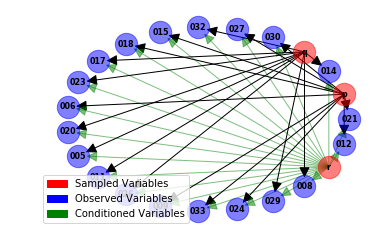

In [5]:
vertices = compiled_python.vertices
create_network_graph(vertices=vertices)
display_graph(vertices=vertices);

## Extracting the latent variables

We have tried to create an interface that allows for simple extraction of all important information, allowing users to seamless integrate PySPPL into their own custom designed inference engines. We shall provide an example of such a system in the next walkthrough. To extract the latent variables, we have three built in class methods `get_cont_vars()` , `get_disc_vars()`, `get_if_vars()` that return either `None` if there exists no variables of a such a type, or a `list` of  strings if there exists variables of such a type. 

In [6]:
model = compiled_python
_cont_latents = None if len(model.gen_cont_vars()) == 0 else model.gen_cont_vars()
_disc_latents = None if len(model.gen_disc_vars()) == 0 else model.gen_disc_vars()
_if_latents = None if len(model.gen_if_vars()) == 0 else model.gen_if_vars()


In [7]:
print('The continuous latent variables are: {0}\nThe discrete latent variables are: {1}\nThe conditional latent variables are: {2}'.format(_cont_latents, _disc_latents, _if_latents))

The continuous latent variables are: ['x30001']
The discrete latent variables are: ['x30002']
The conditional latent variables are: ['x30003']


## Extracting the observables

To see the data that your model is observing, you simply need to collect all vertices are observed. We can easily find this information by calling the `observation` and `is_observed` attributes of each vertex.  This works with a variety of different objects: `ints`, `lists` , `arrays`, `np.array` and `torch.tensors`.

In [8]:

observables = dict([(vertex.name, vertex.observation) for vertex in vertices if vertex.is_observed])
for key in observables:
    print('Printing the observable name: {0} and value: {1}'.format(key, observables[key]))

Printing the observable name: y30021 and value: 4
Printing the observable name: y30014 and value: 1
Printing the observable name: y30030 and value: 0
Printing the observable name: y30027 and value: 4
Printing the observable name: y30032 and value: 6
Printing the observable name: y30015 and value: 1
Printing the observable name: y30018 and value: 0
Printing the observable name: y30017 and value: 0
Printing the observable name: y30023 and value: 3
Printing the observable name: y30006 and value: 4
Printing the observable name: y30020 and value: 4
Printing the observable name: y30005 and value: 4
Printing the observable name: y30011 and value: 4
Printing the observable name: y30026 and value: 4
Printing the observable name: y30009 and value: 5
Printing the observable name: y30033 and value: 6
Printing the observable name: y30024 and value: 3
Printing the observable name: y30029 and value: 0
Printing the observable name: y30008 and value: 5
Printing the observable name: y30012 and value: 4


## Extracting the original parameter names

Parameter names are transformed in the compiler to ensure uniqueness when run in the inference engine of choice. However, to extract the user defined names we simply do the following:



In [9]:
# a list of all latent vars
all_sampled_vars = compiled_python.get_vars()

_number_of_latents = len(all_sampled_vars)
print('There are {} latent variables'.format(_number_of_latents))

print(all_sampled_vars)
_names = dict(
    [(vertex.name, vertex.original_name) for vertex in vertices if vertex.name in all_sampled_vars])# distribution arguments and names


for key in _names:
    print('Unique name in compiler: {0} User defined name:  {1}'.format(key, _names[key]))

There are 3 latent variables
['x30002', 'x30001', 'x30003']
Unique name in compiler: x30002 User defined name:  q
Unique name in compiler: x30001 User defined name:  p
Unique name in compiler: x30003 User defined name:  r


## Extracting the distribution names and parameters

The flexibilty of the system allows the user to manipulate and reconstruct distribution objects, dependent upon the library they want to use.  

In [10]:
_dist_params = {}
for vertex in vertices:
    if vertex.is_sampled:
        _dist_params[vertex.name] = {vertex.distribution_name: vertex.distribution_arguments}


In [11]:
for params in _dist_params:
    print('The sampled variable {0} distribution class is {1} with parameters {2}'.format(params,list(_dist_params[params].keys()), list(_dist_params[params].values())))

The sampled variable x30002 distribution class is ['Poisson'] with parameters [{'rate': '3'}]
The sampled variable x30001 distribution class is ['Normal'] with parameters [{'loc': '0', 'scale': '1'}]
The sampled variable x30003 distribution class is ['Exponential'] with parameters [{'rate': '2'}]


## Extracting distribution type

It is also important to know whether or not a particular vertex is discrete or continuous. This can be found by using the `vertex.is_discrete` and `vertex.is_continuous` attributes.

In [12]:
# distribution type of each latent variable, used for the bijections and embeddings
_cont_dists = dict([(vertex.name, vertex.distribution_name) for vertex in vertices if
                         (vertex.is_continuous and vertex.name in all_sampled_vars)])
_disc_dists = dict([(vertex.name, vertex.distribution_name) for vertex in vertices if
                         (vertex.is_discrete and vertex.name in all_sampled_vars)])

In [13]:
for param in _cont_dists:
    print('The sampled variable is {0} with a continous distribution {1} '.format(param, _cont_dists[param]))
for param in _disc_dists:
     print('The sampled variable is {0} with discrete distribution {1}'.format(param, _disc_dists[param]))

The sampled variable is x30001 with a continous distribution Normal 
The sampled variable is x30003 with a continous distribution Exponential 
The sampled variable is x30002 with discrete distribution Poisson


## Extracting if-else latent variables and their preidcates. 

Each predicate has a cond boolean parameter, which represents the evaluated value of the predicates, evaluated only once the `model.log_pdf(state)`,  or user specified function is called.

To each predicate, that is, for example in the expression `if (x > 1) `, the `x > 1` part, is assigned a special conditional variable, which evaluates the predicate and is then assigned a boolean variable. 

In the model defined above we have:

In [14]:

_cond_bools = None if len(model.gen_if_vars()) == 0 else model.gen_cond_vars()
print(model.get_conditions())


{Condition
  Name:         cond_30004
  Ancestors:    x30003
  Condition:    (state['x30003'] > 2)}


as the `condition` is itself an object, like the `vertices` we can then extract the predicate as follows:

In [15]:
for conditional in model.conditionals:
    print(' The predictate to condition {0} is : {1}'.format(conditional.name, conditional.condition))

 The predictate to condition cond_30004 is : (state['x30003'] > 2)


`state` here corresponds to the `state` of the system. We expand on this further below. 

## How to extract infromation regarding the ancestors

If we need the ancestor history of the latent variables, this is also very easy to extract.

As none of the latent variables in the coal-mining model have dependencies on each other, let us refer back to the simple model in [PySPPL walkthorugh number one](https://github.com/bradleygramhansen/PySPPL/blob/master/examples/pysppl_walkthrough_1.ipynb)

In [16]:
model_purepython="""
mean = sample(poisson(3))
x= sample(gamma(mean,1))
y= 10
observe(normal(x,5), y)
"""
ancestor_model = compile_model(model_purepython, language='python')
vertices = ancestor_model.vertices
ancestors = {}
for v in vertices:
    if v.is_sampled:
        for a in v.ancestors:
            ancestors[a.original_name] = v.original_name

print(ancestors)

{'mean': 'x'}


which tells us that the parameter `mean` is an ancestor of the parameter `x`.

## Generating the prior of the model

To generate the prior we have an inbuilt class method `gen_prior_samples()` that automatically constructs a `state` object. The `state` object is a dictionary that contains the `key-value` pairs of the sampled latent variables and their values, the observables and their values and the conditional nodes and their values. 

In [24]:
state = model.gen_prior_samples()
for k,v in state.items():
    print('Parameter {0} has value {1}'.format(k, v))

Parameter x30001 has value 0.3072734475135803
Parameter x30002 has value 5.0
Parameter x30003 has value 0.9261802434921265
Parameter cond_30004 has value 0
Parameter y30005 has value 4
Parameter y30006 has value 4
Parameter y30008 has value 5
Parameter y30009 has value 5
Parameter y30011 has value 4
Parameter y30012 has value 4
Parameter y30014 has value 1
Parameter y30015 has value 1
Parameter y30017 has value 0
Parameter y30018 has value 0
Parameter y30020 has value 4
Parameter y30021 has value 4
Parameter y30023 has value 3
Parameter y30024 has value 3
Parameter y30026 has value 4
Parameter y30027 has value 4
Parameter y30029 has value 0
Parameter y30030 has value 0
Parameter y30032 has value 6
Parameter y30033 has value 6


## Generating the log pdf of the model 
We have also created an inbuilt function `.gen_log_pdf(dict)` for doing this also. But it requires one argument, that is it requires a dictionary of the `state` of the system. For example, using the value of the state generated above from `model.gen_prior_samples()`:

In [25]:
print(model.gen_log_pdf(state))

AttributeError: 'Normal' object has no attribute 'log_pdf'